In [1]:
import numpy as np
import keras
from keras.datasets import fashion_mnist
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def sigmoid(a):
    s = 1/(1+np.exp(-a))
    return s

def derivative_sigmoid(a):
    ds = sigmoid(a) *(1-sigmoid (a))
    return ds

def tanh(a):
    t=(np.exp(a)-np.exp(-a))/(np.exp(a)+np.exp(-a))
    return t

def derivative_tanh(a):
    dt=1-tanh(a)**2
    return dt


def softmax(a):
    return np.exp(a) / np.sum(np.exp(a), axis=0) #expA (axis=0, keepdims=True)

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = fashion_mnist.load_data()

In [5]:
def initialize_parameters(layer_dimensions):

    #np.random.seed(0)
    parameters = {}
    L = len(layer_dimensions)            # number of layers in the network

    for k in range(1, L):
        
        parameters['w' + str(k)] = np.random.randn(layer_dimensions[k], layer_dimensions[k-1]) 
        parameters['b' + str(k)] = np.zeros((layer_dimensions[k], 1))
        
    return parameters

In [6]:
def agrregation_forward(h, w, b):
    
    a = np.dot(w, h) + b
    temp = (h,w,b)
    
    return a ,temp

In [7]:
def activation_forward(h_prev, w, b, activation):
        
    
    if activation == "sigmoid":

        a, linear_temp = agrregation_forward(h_prev, w, b)
        h = sigmoid(a)
    
    elif activation == "tanh":
        a, linear_temp = agrregation_forward(h_prev, w, b)
        h = tanh(a)
        
    elif activation == "softmax":
        a, linear_temp = agrregation_forward(h_prev, w, b)
        h = softmax(a)
    
    
    temp = (linear_temp, a)

    return h, temp

In [8]:
def forward_pass(x, parameters):

    temps = []
    h = x
    L = len(parameters) // 2                  # number of layers in the neural network
    
    for k in range(L-1):
        l = k+1
        h_prev = h 
        h,temp = activation_forward(h_prev, parameters['w'+str(l)], parameters['b'+str(l)], activation="sigmoid")
        temps.append(temp)
    
    
    hL,temp1 = activation_forward(h, parameters['w'+str(L)], parameters['b'+str(L)], activation="softmax")
    temps.append(temp1)
    
            
    return hL, temps

In [9]:
def cost_function(yhat, y):   
    m = y.shape[1] # no. of examples
  
    product_sum = np.sum((y *np.log(yhat)), axis = 0)
    cost = -1/m*np.sum(product_sum)
    
    return cost

In [10]:
def agrregation_backward(dL_da, temp):
    
    h_prev, w, b = temp 
    m = h_prev.shape[1]
    dL_dh_prev = np.dot(w.T, dL_da)
    
    dL_dw = 1/m*np.dot(dL_da, h_prev.T)
    dL_db = 1/m*np.sum(dL_da, axis=1, keepdims=True)
     

    return dL_dh_prev, dL_dw, dL_db

In [11]:
def activation_backward(dL_dh, temp, activation):

    linear_temp, a = temp
    
    if activation == "sigmoid":
        ds = derivative_sigmoid(a)
        dL_da = dL_dh * ds
       
        dL_dh_prev, dL_dw, dL_db = agrregation_backward(dL_da, linear_temp)    
        
    elif activation == "tanh":
        dt = derivative_tanh(a)
        dL_da = dL_dh * dt

        dL_dh_prev, dL_dw, dL_db = agrregation_backward(dL_da, linear_temp)    
    
    return dL_dh_prev, dL_dw, dL_db

In [12]:
def backward_pass(yhat, y, temps):
    
    grads = {}
    L = len(temps) # the number of layers
    m = y.shape[1]

# el = one hot vector
    el = y
    dL_dyhat = -(1/yhat)*el
    dL_daL  = -(el - yhat)
    current_temp = temps[L-1]
    linear_tempL,aL = current_temp
    
    hL_prev, wL, bL = linear_tempL
    m = hL_prev.shape[1]

    dL_dhL_prev = np.dot(wL.T, dL_daL)
    
    dL_dwL = 1/m*np.dot(dL_daL, hL_prev.T)
    dL_dbL = 1/m*np.sum(dL_daL, axis=1, keepdims=True)

    
    grads["dL_dh" + str(L-1)] = dL_dhL_prev
    grads["dL_dw" + str(L)]      = dL_dwL
    grads["dL_db" + str(L)] = dL_dbL
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        #print(l)
        current_temp = temps[l]
        dL_dh_prev, dL_dw, dL_db = activation_backward(grads["dL_dh" + str(l+1)], current_temp, "sigmoid")
        grads["dL_dh" + str(l)] = dL_dh_prev
        grads["dL_dw" + str(l + 1)] = dL_dw
        grads["dL_db" + str(l + 1)] = dL_db

    return grads

In [13]:
def parameter_update(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["w" + str(l+1)] = parameters["w" + str(l+1)]-learning_rate*grads["dL_dw" + str(l + 1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads["dL_db" + str(l + 1)]

    return parameters

In [27]:
def predict(x, y, parameters):
    
    m = x.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    prob, temps = forward_pass(x, parameters)
    

    predicted_label = np.argmax(prob, axis=0)
    true_label = np.argmax(y, axis=0)
    
    Accuracy = np.sum(predicted_label == true_label)/m
        
#         if probas[0,i] > 0.5:
#             p[0,i] = 1
#         else:
#             p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(Accuracy))
        
    return

In [15]:
x_train_orig = x_train_orig[:5000]
x_test_orig = x_test_orig[:50]
y_train_orig = y_train_orig[:5000]
y_test_orig = y_train_orig[:50]
y_train_orig.shape

(5000,)

In [30]:
x_train_flatten = x_train_orig.reshape(x_train_orig.shape[0], -1).T
x_test_flatten = x_test_orig.reshape(x_test_orig.shape[0], -1).T
x_train = x_train_flatten/255
x_test = x_test_flatten/255

print ("x_train's shape: " + str(x_train.shape))
print ("x_test's shape: " + str(x_test.shape))


x_train's shape: (784, 5000)
x_test's shape: (784, 50)


In [31]:
# index = 15
# plt.imshow(x_train_orig[index])
# print ("y = " + str(y_train_orig[index])+ ". It's a " + class_names[y_train_orig[index]] +  " picture.")

In [32]:
no_hidden_layers = 3 # no of hidden layers
no_neuron_hidden = 50 # no. of neurons in each hidden layers
no_neuron_output = 10 # # no. of neurons in each hidden layers

In [33]:
no_of_training_examples = np.shape(x_train)[1]
no_of_testing_examples = np.shape(x_test)[1]
size_input_layer = np.shape(x_train)[0]
size_hidden_layer = no_neuron_hidden
size_output_layer = no_neuron_output

In [34]:
y_train_orig.shape[0]

5000

In [35]:
def one_hot_vector_form(labels,size_output_layer):
    no_of_examples = labels.shape[0]
    one_hot_vector = np.zeros((no_of_examples , size_output_layer))
    for i in range(no_of_examples):
        one_hot_vector[i, labels[i]] = 1    
        y = one_hot_vector.T
    return y  

In [36]:
y_train = one_hot_vector_form(y_train_orig,size_output_layer)
y_test = one_hot_vector_form(y_test_orig,size_output_layer)
y_test.shape

(10, 50)

In [37]:
layer_dimensions = [size_input_layer]+ [size_hidden_layer]*no_hidden_layers+ [size_output_layer]
layer_dimensions

[784, 50, 50, 50, 10]

In [24]:
def L_layer_network(x, y, layer_dimensions, learning_rate = 0.0075, num_iterations=1000, print_cost=False):
    

    np.random.seed(1)
    costs = []          
    
    parameters = initialize_parameters(layer_dimensions)
 
    for i in range(0, num_iterations):
       
        yhat, temps = forward_pass(x, parameters)
 
        cost = cost_function(yhat, y)
        
        grads = backward_pass(yhat,y,temps)
        
        parameters = parameter_update(parameters, grads, learning_rate)
        
        #print("cost in iteration ",i," is =",cost)
                
            # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 7.897121
Cost after iteration 100: 3.736447
Cost after iteration 200: 2.911341
Cost after iteration 300: 2.443653
Cost after iteration 400: 2.203975


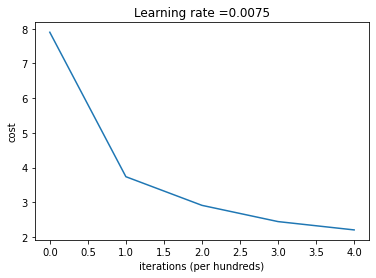

In [25]:
parameters = L_layer_network(x_train, y_train, layer_dimensions,learning_rate = 0.0075, num_iterations = 1000, print_cost = True)

In [28]:
predict(x_train,y_train,parameters)

Accuracy: 0.2554


In [29]:
predict(x_test,y_test,parameters)

Accuracy: 0.1


In [40]:
x_train[:,[1]]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00392157],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.16078431],
       [0.7372549 ],
       [0.40392157],
       [0.21176471],
       [0.18823529],
       [0.16862745],
       [0.34117647],
       [0.65882353],
       [0.52156863],
       [0.0627451 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00392157],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.19215686],
       [0.53333333],
       [0.85882353],
       [0.84705882],
       [0.89411765],
       [0.9254902 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.85098039],
       [0.84313725],
       [0.996